In [15]:
pywt.dwt_max_level(200, 'sym9')

3

In [2]:
import numpy as np
from skimage.restoration import denoise_wavelet

def smooth_with_wavelets(y, level):
    # Apply wavelet denoising using the BayesShrink method
    y_denoised = denoise_wavelet(y, wavelet= 'sym4', method='VisuShrink', mode='soft', rescale_sigma=True, wavelet_levels=level)

    return y_denoised


## Apply wavelet to entire datasets. 

### This will cause leakage on test set though. 

In [4]:
import pywt
import numpy as np

# Load the data from the .txt file
data_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\Stock data\JSE_clean_truncated.txt'
data = np.loadtxt(data_path, delimiter=',')

# Apply wavelet transformation to each column
wavelet_data_leak = np.zeros_like(data)
for i in range(data.shape[1]):
    wavelet_data_leak[:, i] = smooth_with_wavelets(data[:, i], pywt.dwt_max_level(len(data[:, i]), 'sym4'))

# Save the wavelet transformed data to a new .txt file
output_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\preprocessing\wavelet_jse.txt'
np.savetxt(output_path, wavelet_data_leak, delimiter=',', fmt='%.8f')


### Example visualisation of AUDCAD

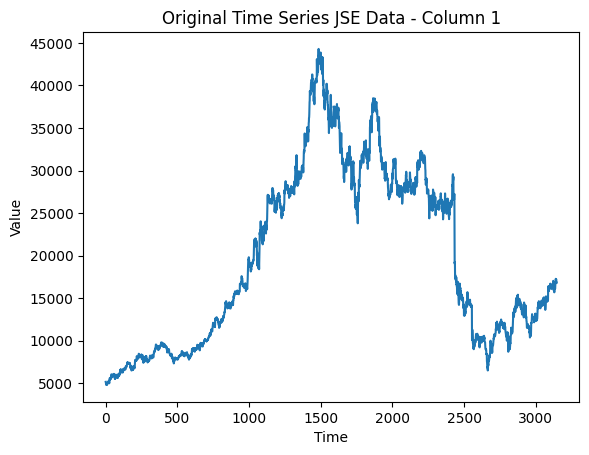

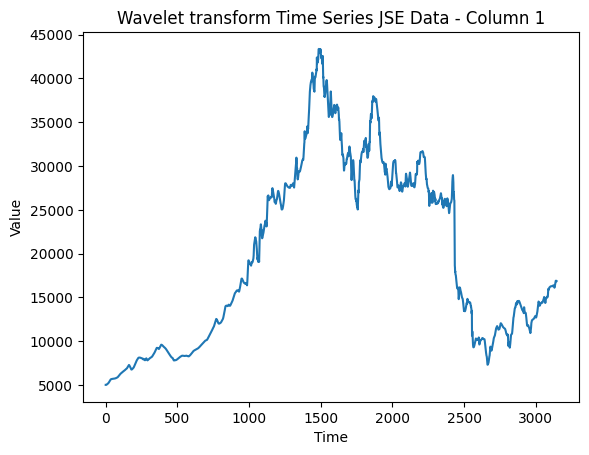

In [5]:
import matplotlib.pyplot as plt

# Plot the first column of the original time series jse data
plt.plot(data[:, 0])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original Time Series JSE Data - Column 1')
plt.show()

# Plot the first column of the original time series forex data
plt.plot(wavelet_data_leak[:, 0])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Wavelet transform Time Series JSE Data - Column 1')
plt.show()



## Let's see return series of original data and denoised data


In [6]:
def calculate_log_returns(closing_prices):
    # Shift the closing prices by one position
    shifted_prices = np.roll(closing_prices, 1)

    # Calculate the logarithmic returns for each value in the closing prices
    log_returns = np.log(closing_prices / shifted_prices)

    # The first value in log_returns will be -inf due to the shift, so we set it to NaN
    log_returns[0] = np.nan

    return log_returns


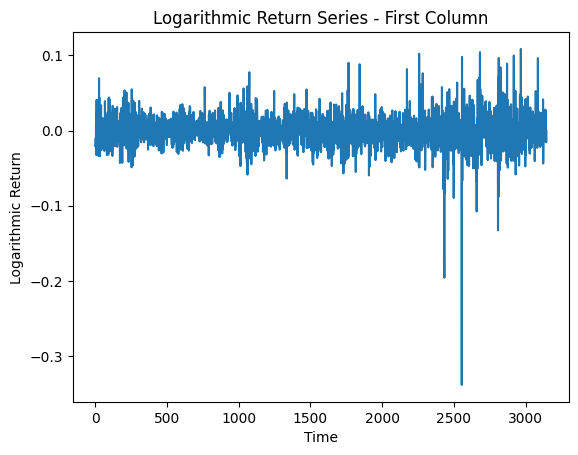

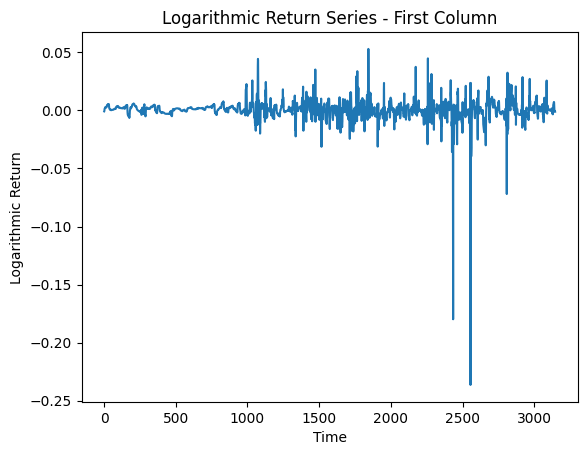

In [7]:
log_returns = calculate_log_returns(data[:, 0])
plt.plot(log_returns)
plt.xlabel('Time')
plt.ylabel('Logarithmic Return')
plt.title('Logarithmic Return Series - First Column')
plt.show()

log_returns = calculate_log_returns(wavelet_data_leak[:, 0])
plt.plot(log_returns)
plt.xlabel('Time')
plt.ylabel('Logarithmic Return')
plt.title('Logarithmic Return Series - First Column')
plt.show()



## Need to apply wavelet transformation using rolling window method to prevent data leakage

In [25]:
import numpy as np
import pywt


def preprocess_wavelet(data_path, window_size):
    # Load the data
    data = np.loadtxt(data_path, delimiter=',')

    # Initialize the wavelet data list
    wavelet_data = []

    # Loop over each column
    for i in range(data.shape[1]):
        column_data = []
        # Loop over the data in chunks of window_size entries, starting from the window_size-th entry
        for j in range(window_size, data.shape[0], window_size):
            # Apply the smooth_with_wavelets function to each chunk
            chunk = data[j-window_size:j, i]
            column_data.append(smooth_with_wavelets(chunk, pywt.dwt_max_level(window_size, 'sym4')))
        # Convert the column data to a numpy array and append it to the wavelet data list
        wavelet_data.append(np.concatenate(column_data))

    # Convert the wavelet data list to a numpy array
    wavelet_data = np.column_stack(wavelet_data)
    
    # Remove the overlapping data from the beginning
    wavelet_data = wavelet_data[window_size:]

    # Save the wavelet data to a new .txt file
    np.savetxt('jse_wavelet_data_{}.txt'.format(window_size), wavelet_data, delimiter=',', fmt='%.8f')


### 30 day

In [16]:
# Load the data
data_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\Stock data\JSE_clean_truncated.txt'
data = np.loadtxt(data_path, delimiter=',')

# Initialize the wavelet data list
wavelet_data = []

# Loop over each column
for i in range(data.shape[1]):
    column_data = []
    # Loop over the data in chunks of 30 entries, starting from the 30th entry
    for j in range(90, data.shape[0], 90):
        # Apply the smooth_with_wavelets function to each chunk
        chunk = data[j-90:j, i]
        column_data.append(smooth_with_wavelets(chunk, pywt.dwt_max_level(len(chunk), 'sym4')))
    # Convert the column data to a numpy array and append it to the wavelet data list
    wavelet_data.append(np.concatenate(column_data))

# Convert the wavelet data list to a numpy array
wavelet_data = np.column_stack(wavelet_data)

# Save the wavelet data to a new .txt file
np.savetxt('JSE_wavelet_data_90.txt', wavelet_data, delimiter=',', fmt='%.8f')

In [27]:
def preprocess_no_denoise(data_path, window_size):
    # Load the data
    data = np.loadtxt(data_path, delimiter=',')

    # Initialize the wavelet data list
    wavelet_data = []

    # Loop over each column
    for i in range(data.shape[1]):
        column_data = []
        # Loop over the data in chunks of window_size entries, starting from the window_size-th entry
        for j in range(window_size, data.shape[0], window_size):
            # Append the chunk to the column data
            chunk = data[j-window_size:j, i]
            column_data.append(chunk)
        # Convert the column data to a numpy array and append it to the wavelet data list
        wavelet_data.append(np.concatenate(column_data))

    # Convert the wavelet data list to a numpy array
    wavelet_data = np.column_stack(wavelet_data)

    # Remove the overlapping data from the beginning
    wavelet_data = wavelet_data[window_size:]

    # Save the wavelet data to a new .txt file
    np.savetxt('JSE_no_denoise_data_{}.txt'.format(window_size), wavelet_data, delimiter=',', fmt='%.8f')




In [26]:
# 90 day

data_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\Stock data\JSE_clean_truncated.txt'
window_size = 90
preprocess_wavelet(data_path, window_size)





## Compare with actual values for trend prediction performance measure

In [29]:
# Example usage:
data_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\Stock data\JSE_clean_truncated.txt'

window_size = 90
preprocess_no_denoise(data_path, window_size)

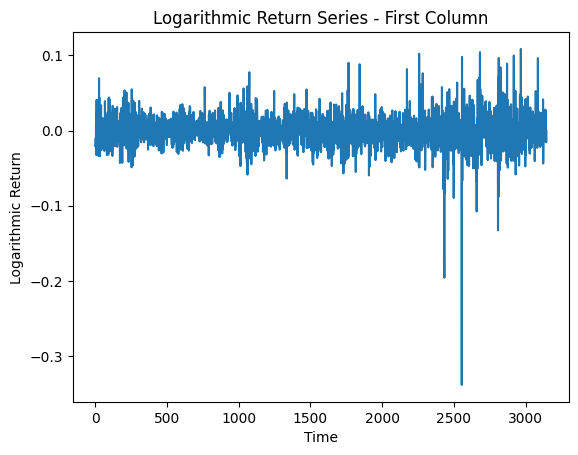

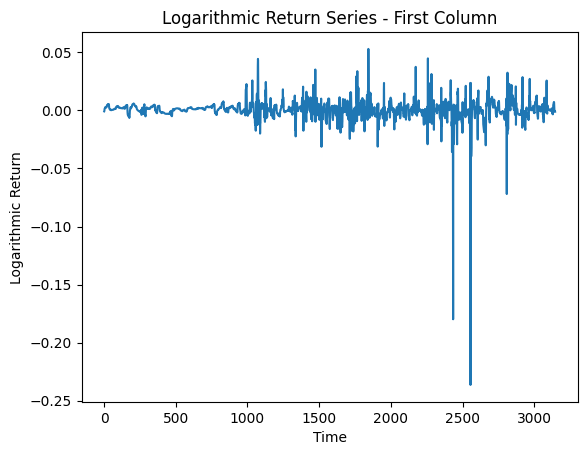

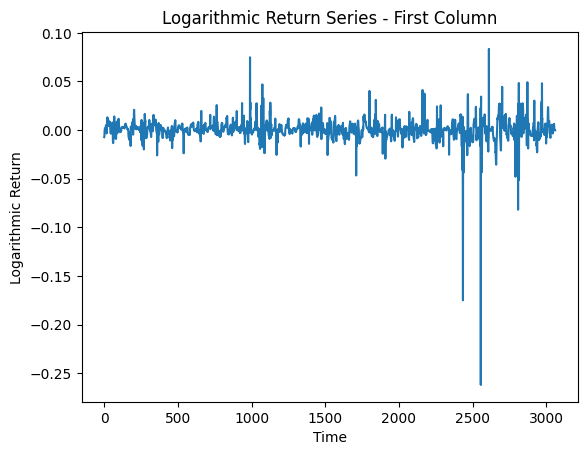

In [20]:
log_returns = calculate_log_returns(data[:, 0])
plt.plot(log_returns)
plt.xlabel('Time')
plt.ylabel('Logarithmic Return')
plt.title('Logarithmic Return Series - First Column')
plt.show()


log_returns = calculate_log_returns(wavelet_data_leak[:, 0])
plt.plot(log_returns)
plt.xlabel('Time')
plt.ylabel('Logarithmic Return')
plt.title('Logarithmic Return Series - First Column')
plt.show()

log_returns = calculate_log_returns(wavelet_data[:, 0])
plt.plot(log_returns)
plt.xlabel('Time')
plt.ylabel('Logarithmic Return')
plt.title('Logarithmic Return Series - First Column')
plt.show()


In [21]:
# Initialize an empty list to hold the log returns
log_returns = []

# Loop over each column in the wavelet_data
for i in range(wavelet_data.shape[1]):
    # Calculate the log returns for the current column
    column_log_returns = calculate_log_returns(wavelet_data[:, i])
    # Append the log returns to the list
    log_returns.append(column_log_returns)

# Convert the list of log returns to a numpy array
log_returns = np.column_stack(log_returns)

# Save the log returns to a new .txt file
np.savetxt('JSE_wavelet_returns.txt', log_returns, delimiter=',', fmt='%.8f')

In [22]:
import numpy as np

def calculate_log_returns_for_files(file_paths):
    for file_path in file_paths:
        # Load the wavelet data
        wavelet_data = np.loadtxt(file_path, delimiter=',')

        # Initialize an empty list to hold the log returns
        log_returns = []

        # Loop over each column in the wavelet_data
        for i in range(wavelet_data.shape[1]):
            # Calculate the log returns for the current column
            column_log_returns = calculate_log_returns(wavelet_data[:, i])
            # Append the log returns to the list
            log_returns.append(column_log_returns)

        # Convert the list of log returns to a numpy array
        log_returns = np.column_stack(log_returns)

        # Extract the number from the file path
        number = file_path.split('_')[-1].split('.')[0]

        # Save the log returns to a new .txt file
        np.savetxt(f'data_{number}.txt', log_returns, delimiter=',', fmt='%.8f')

# Example usage:
file_paths = [
    r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\preprocessing\JSE_wavelet_data_90.txt'
]
calculate_log_returns_for_files(file_paths)

In [30]:
import numpy as np

# Load the time series data
data_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\preprocessing\JSE_no_denoise_data_90.txt'
data = np.loadtxt(data_path, delimiter=',')

# Calculate the log returns for each column
log_returns = np.log(data[1:] / data[:-1])

# Save the log returns to a new .txt file
output_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\preprocessing\JSE_data_90_actual.txt'
np.savetxt(output_path, log_returns, delimiter=',', fmt='%.8f')



In [276]:
import numpy as np

# Load the time series data
data_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\preprocessing\no_denoise_data_90.txt'
data = np.loadtxt(data_path, delimiter=',')

# Calculate the log returns for each column
log_returns = np.log(data[1:] / data[:-1])

# Save the log returns to a new .txt file
output_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\preprocessing\data_90_actual.txt'
np.savetxt(output_path, log_returns, delimiter=',', fmt='%.8f')

In [278]:
import numpy as np

# Load the time series data
data_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\preprocessing\no_denoise_data_128.txt'
data = np.loadtxt(data_path, delimiter=',')

# Calculate the log returns for each column
log_returns = np.log(data[1:] / data[:-1])

# Save the log returns to a new .txt file
output_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\preprocessing\data_128_actual.txt'
np.savetxt(output_path, log_returns, delimiter=',', fmt='%.8f')

In [279]:
import numpy as np

# Load the time series data
data_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\preprocessing\no_denoise_data_256.txt'
data = np.loadtxt(data_path, delimiter=',')

# Calculate the log returns for each column
log_returns = np.log(data[1:] / data[:-1])

# Save the log returns to a new .txt file
output_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\preprocessing\data_256_actual.txt'
np.savetxt(output_path, log_returns, delimiter=',', fmt='%.8f')

In [280]:
import numpy as np

# Load the time series data
data_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\preprocessing\no_denoise_data_512.txt'
data = np.loadtxt(data_path, delimiter=',')

# Calculate the log returns for each column
log_returns = np.log(data[1:] / data[:-1])

# Save the log returns to a new .txt file
output_path = r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\preprocessing\data_512_actual.txt'
np.savetxt(output_path, log_returns, delimiter=',', fmt='%.8f')

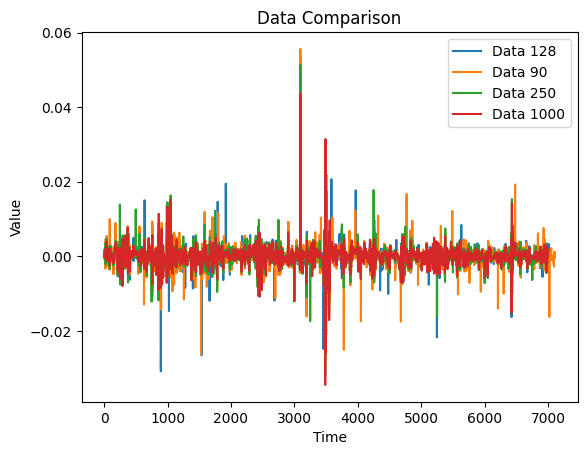

In [232]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the files
data_128 = np.loadtxt(r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\data_128.txt', delimiter=',')
data_90 = np.loadtxt(r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\data_90.txt', delimiter=',')
data_250 = np.loadtxt(r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\data_250.txt', delimiter=',')
data_1000 = np.loadtxt(r'C:\Users\22941940\2024\Coding\Article\MTGNN\data\data_1000.txt', delimiter=',')

# Plot the data from data_128.txt
plt.plot(data_128[:, 0], label='Data 128')

# Plot the data from data_90.txt
plt.plot(data_90[:, 0], label='Data 90')

# Plot the data from data_250.txt
plt.plot(data_250[:, 0], label='Data 250')

# Plot the data from data_1000.txt
plt.plot(data_1000[:, 0], label='Data 1000')

# Add labels and title to the plot
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Data Comparison')

# Add legend to the plot
plt.legend()

# Show the plot
plt.show()


In [233]:
import numpy as np

def preprocess_no_denoise(data_path, window_size):
    # Load the data
    data = np.loadtxt(data_path, delimiter=',')

    # Initialize the wavelet data list
    wavelet_data = []

    # Loop over each column
    for i in range(data.shape[1]):
        column_data = []
        # Loop over the data in chunks of window_size entries, starting from the window_size-th entry
        for j in range(window_size, data.shape[0], window_size):
            # Append the chunk to the column data
            chunk = data[j-window_size:j, i]
            column_data.append(chunk)
        # Convert the column data to a numpy array and append it to the wavelet data list
        wavelet_data.append(np.concatenate(column_data))

    # Convert the wavelet data list to a numpy array
    wavelet_data = np.column_stack(wavelet_data)

    # Save the wavelet data to a new .txt file
    np.savetxt('no_denoise_data_{}.txt'.format(window_size), wavelet_data, delimiter=',', fmt='%.8f')
